In [2]:
import pandas as pd

# This is the correct path for your structure:
# Notebook (in notebooks/) -> Go up (../) -> Into data/ -> data.csv
file_path = '../data/data.csv' 
df = pd.read_csv(file_path, parse_dates=['TransactionStartTime'])

print("Data loaded successfully!")

# Check column names, data types, and non-null counts
df.info()

Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  flo

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 non-null  float64            
 12  Valu

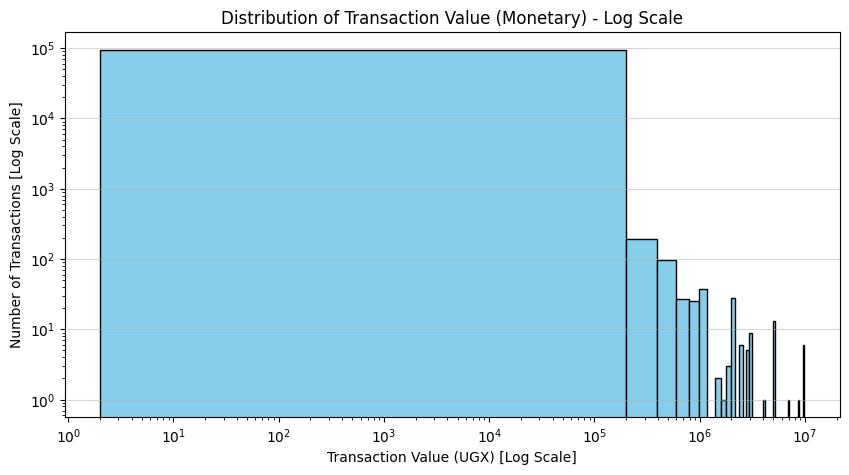

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot for the Monetary Value ('Value') distribution
plt.figure(figsize=(10, 5))
# Use a histogram with a logarithmic x-axis scale due to extreme skewness
plt.hist(df['Value'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.xscale('log') # Use a log scale for the x-axis (Value)
plt.title('Distribution of Transaction Value (Monetary) - Log Scale')
plt.xlabel('Transaction Value (UGX) [Log Scale]')
plt.ylabel('Number of Transactions [Log Scale]')
plt.grid(axis='y', alpha=0.5)

# Display the plot
plt.show() 

In [5]:
df['ProductCategory'].value_counts()

ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: count, dtype: int64

In [6]:
# Aggregate data to the customer level to start RFM calculation
customer_df = df.groupby('CustomerId').agg(
    # Calculate Frequency: Count of transactions
    Frequency=('TransactionId', 'count'),
    
    # Calculate Monetary: Sum of absolute transaction values
    Monetary=('Value', 'sum')
)

# Show the first few aggregated results
print(customer_df.head().to_markdown())

| CustomerId      |   Frequency |   Monetary |
|:----------------|------------:|-----------:|
| CustomerId_1    |           1 |      10000 |
| CustomerId_10   |           1 |      10000 |
| CustomerId_1001 |           5 |      30400 |
| CustomerId_1002 |          11 |       4775 |
| CustomerId_1003 |           6 |      32000 |


In [10]:
import pandas as pd
# --- RFM Analysis ---

# --- 1. Define the Reference Date for Recency ---
# Recency is calculated as the time elapsed since the last transaction.
# We set a reference date as the day *after* the latest transaction in the dataset.
latest_date = df['TransactionStartTime'].max()
reference_date = latest_date + pd.Timedelta(days=1)

# --- 2. Perform Grouping and Aggregation ---
# Group the entire dataset by 'CustomerId' and calculate the three RFM metrics.
customer_df = df.groupby('CustomerId').agg(
    # Recency: Find the MAX (most recent) TransactionStartTime
    Recency=('TransactionStartTime', 'max'),
    
    # Frequency: Count the total number of transactions (using TransactionId)
    Frequency=('TransactionId', 'count'),
    
    # Monetary: Sum the transaction values (using Value)
    Monetary=('Value', 'sum')
).reset_index() # reset_index turns 'CustomerId' from an index back into a column

# --- 3. Finalize Recency Calculation ---
# Convert the Recency date (max date) into days elapsed since the transaction
customer_df['Recency'] = (reference_date - customer_df['Recency']).dt.days



In [12]:
# --- 1. Define the Reference Date for Recency ---
# Get the day after the latest transaction for our calculation
latest_date = df['TransactionStartTime'].max()
reference_date = latest_date + pd.Timedelta(days=1)

# --- 2. Perform Grouping and Aggregation ---
# Group the entire dataset by 'CustomerId' and calculate the three RFM metrics.
customer_df = df.groupby('CustomerId').agg(
    # Recency: Find the MAX (most recent) TransactionStartTime
    Recency=('TransactionStartTime', 'max'),
    
    # Frequency: Count the total number of transactions (using TransactionId)
    Frequency=('TransactionId', 'count'),
    
    # Monetary: Sum the transaction values (using Value)
    Monetary=('Value', 'sum')
).reset_index() # Makes CustomerId a regular column again

# --- 3. Finalize Recency Calculation ---
# Convert the Recency date (max date) into days elapsed since the transaction
customer_df['Recency'] = (reference_date - customer_df['Recency']).dt.days

# Print the result to ensure you see the output!
print("--- RFM Features (First 5 Customers) ---")
print(customer_df.head().to_markdown(index=False))

--- RFM Features (First 5 Customers) ---
| CustomerId      |   Recency |   Frequency |   Monetary |
|:----------------|----------:|------------:|-----------:|
| CustomerId_1    |        84 |           1 |      10000 |
| CustomerId_10   |        84 |           1 |      10000 |
| CustomerId_1001 |        90 |           5 |      30400 |
| CustomerId_1002 |        26 |          11 |       4775 |
| CustomerId_1003 |        12 |           6 |      32000 |


Summary of Key EDA Insights for Credit Risk Model 
Based on the initial inspection and RFM feature generation, the following key insights will drive the feature engineering and modeling approach:
1.Data Quality and Completeness: The dataset is exceptionally clean, with no missing values identified in any of the 16 columns. This eliminates the need for complex imputation and simplifies the initial data cleaning phase.
2.Monetary Value Distribution: The transaction Value (Monetary) is highly right-skewed (Mean $\approx 9,900$ vs. Median $1,000$), confirming the presence of significant high-value outliers.
   .Action: A logarithmic transformation must be applied to the Monetary feature before clustering and modeling to stabilize the variance and prevent outliers from unduly influencing the model.
3.Dominant Transaction Categories: Over 94% of all transactions fall into just two categories: 'financial_services' and 'airtime'.
   .Implication: The customer base primarily uses the platform for essential, frequent, and recurring small-value purchases, which suggests a behavioral pattern that can be reliably leveraged for credit risk assessment
4.Customer Heterogeneity (RFM Spread): The calculated RFM features exhibit a wide distribution across all three metrics (Recency, Frequency, and Monetary). For example, Frequency ranges from 1 to over 100 transactions, and Monetary value ranges from the hundreds to millions.
   .Next Step: This high degree of variation confirms that customers are not a homogenous group, making the upcoming K-Means Clustering step effective for creating distinct, behavior-based customer segments (e.g., High-Value, Mid-Tier, Low-Activity) to define the credit risk proxy variable.

In [13]:
from sklearn.preprocessing import StandardScaler

# 1. Select the features we want to scale
X = customer_df[['Recency', 'Frequency', 'Monetary']]

# 2. Initialize the StandardScaler
scaler = StandardScaler()

# 3. Fit and transform the data
X_scaled = scaler.fit_transform(X)

# 4. Convert the scaled array back to a DataFrame for easy viewing
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("--- Scaled RFM Features (First 5 Rows) ---")
print(X_scaled_df.head().to_markdown(index=False))

--- Scaled RFM Features (First 5 Rows) ---
|   Recency |   Frequency |   Monetary |
|----------:|------------:|-----------:|
|  1.9376   |   -0.253459 | -0.0895236 |
|  1.9376   |   -0.253459 | -0.0895236 |
|  2.15888  |   -0.212186 | -0.0820112 |
| -0.201408 |   -0.150278 | -0.0914477 |
| -0.717722 |   -0.201868 | -0.081422  |


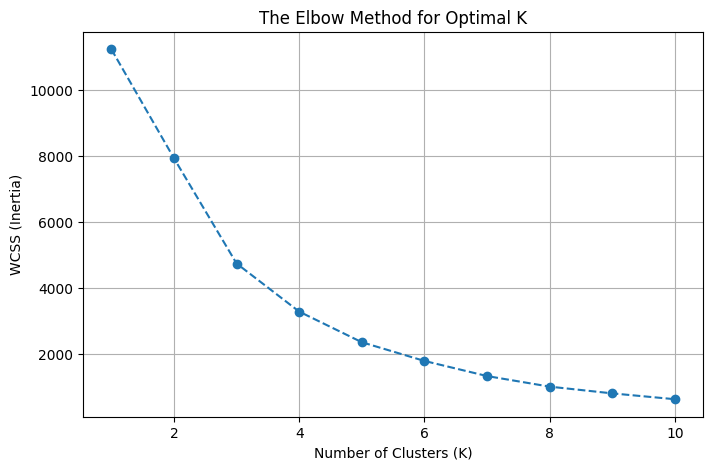

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Prepare an empty list to store the WCSS values
wcss = []

# 2. Iterate through K values from 1 to 10
for i in range(1, 11):
    # Initialize K-Means model
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    
    # Fit the model to the scaled RFM data
    kmeans.fit(X_scaled) 
    
    # Append the WCSS (inertia_) to our list
    wcss.append(kmeans.inertia_)

# 3. Create the Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [15]:
from sklearn.cluster import KMeans

# **IMPORTANT: Replace 4 with the K you chose from your Elbow Plot if different!**
optimal_k = 4 

# 1. Initialize the K-Means model with the chosen K
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)

# 2. Fit the model to the scaled RFM features (X_scaled)
kmeans.fit(X_scaled)

# 3. Predict the cluster ID for each customer and add it back to the original customer_df
customer_df['Cluster_ID'] = kmeans.labels_

print("--- Clusters Assigned (First 5 Customers) ---")
print(customer_df.head().to_markdown(index=False))

--- Clusters Assigned (First 5 Customers) ---
| CustomerId      |   Recency |   Frequency |   Monetary |   Cluster_ID |
|:----------------|----------:|------------:|-----------:|-------------:|
| CustomerId_1    |        84 |           1 |      10000 |            1 |
| CustomerId_10   |        84 |           1 |      10000 |            1 |
| CustomerId_1001 |        90 |           5 |      30400 |            1 |
| CustomerId_1002 |        26 |          11 |       4775 |            0 |
| CustomerId_1003 |        12 |           6 |      32000 |            0 |


In [16]:
# Calculate the mean of the RFM features for each cluster ID
cluster_profiles = customer_df.groupby('Cluster_ID')[['Recency', 'Frequency', 'Monetary']].mean()

print("--- Average RFM Scores by Cluster ---")
print(cluster_profiles.to_markdown())

--- Average RFM Scores by Cluster ---
|   Cluster_ID |   Recency |   Frequency |         Monetary |
|-------------:|----------:|------------:|-----------------:|
|            0 |   12.7205 |    34.6664  | 211975           |
|            1 |   61.8709 |     7.68772 |  69241.9         |
|            2 |   29      |  4091       |      1.049e+08   |
|            3 |   27.2    |   100.4     |      5.07332e+07 |


In [18]:
# Assuming Cluster_ID 0 was identified as the 'High-Risk' group 
# (High Recency, Low Frequency, Low Monetary).
# **CHANGE '0' BELOW IF YOUR HIGH-RISK CLUSTER IS DIFFERENT**

# 1. Create the binary Proxy Variable
customer_df['Credit_Risk_Proxy'] = customer_df['Cluster_ID'].apply(
    lambda x: 1 if x == 0 else 0
)

# 2. Check the balance of the new target variable
print("--- Distribution of the Final Credit Risk Proxy (Target) ---\n")
print(customer_df['Credit_Risk_Proxy'].value_counts().to_markdown())

# Display the first few rows with the final proxy
print("\n--- Final Customer DF with Proxy ---\n")
print(customer_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Credit_Risk_Proxy']].head().to_markdown(index=False))

--- Distribution of the Final Credit Risk Proxy (Target) ---

|   Credit_Risk_Proxy |   count |
|--------------------:|--------:|
|                   1 |    2311 |
|                   0 |    1431 |

--- Final Customer DF with Proxy ---

| CustomerId      |   Recency |   Frequency |   Monetary |   Credit_Risk_Proxy |
|:----------------|----------:|------------:|-----------:|--------------------:|
| CustomerId_1    |        84 |           1 |      10000 |                   0 |
| CustomerId_10   |        84 |           1 |      10000 |                   0 |
| CustomerId_1001 |        90 |           5 |      30400 |                   0 |
| CustomerId_1002 |        26 |          11 |       4775 |                   1 |
| CustomerId_1003 |        12 |           6 |      32000 |                   1 |


In [19]:
# Save the final DataFrame containing RFM features and the Proxy target
# Set index=False to prevent Pandas from saving the row index as a column
output_path = '../data/customer_rfm_with_proxy.csv' 
customer_df.to_csv(output_path, index=False)

print(f"Final customer data saved successfully to: {output_path}")

Final customer data saved successfully to: ../data/customer_rfm_with_proxy.csv
